In [1]:
import torch
import numpy as np
from sbi.inference import prepare_for_sbi, SNLE
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian
import sbi.utils as sbi_utils

pyknos/nflows/nn/nde


### Load theta and x

In [3]:
data = np.load('../../../arco_sims/hay_objectives_init_noise/hay_objectives_noisy.npz', allow_pickle=True)

x = torch.as_tensor(data['data'], dtype=torch.float32)
theta = torch.as_tensor(data['params'], dtype=torch.float32)

In [4]:
x.shape

torch.Size([2000000, 11])

In [5]:
import sys
sys.path.append('../')

In [6]:
from parameter_setup import load_ground_truth_params, load_prior_min, load_prior_max

### Load data to standardize - needed to standardize x_o

In [7]:
#standardize_vals = np.load('../results/standardize_vals.npz')
#x_mean = standardize_vals['data_mean']
#x_std = standardize_vals['data_std']
#
#theta_mean = standardize_vals['theta_mean']
#theta_std = standardize_vals['theta_std']

x_mean = x.mean(dim=0)
x_std = x.std(dim=0)

theta_mean = theta.mean(dim=0)
theta_std = theta.std(dim=0)

In [8]:
x = (x-x_mean) / x_std
theta = (theta-theta_mean) / theta_std

### Load x_o (which I got from running the simulator with Arco's ground truth params)

In [9]:
import numpy as np
x_o = torch.as_tensor(np.load('../results/observation/x_o_hay.npz')['x_o'], dtype=torch.float32)
x_o = (x_o - x_mean) / x_std
x_o = x_o.unsqueeze(0)

### Create dummy simulator and dummy prior

In [48]:
def dummy_simulator(theta):
    return torch.ones(1,11)

dummy_prior = sbi_utils.BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))
_bound = torch.sqrt(torch.as_tensor(3.))
dummy_prior_norm = sbi_utils.BoxUniform(-_bound*torch.ones(35), _bound*torch.ones(35))

In [49]:
from sbi.utils.get_nn_models import likelihood_nn, posterior_nn

In [50]:
simulator, prior, x_shape = prepare_for_sbi(dummy_simulator, dummy_prior_norm)

nsf = likelihood_nn(
    model='nsf',
    theta_shape=prior.sample().shape,
    x_o_shape=x_shape,
    hidden_features=100,
    flow_num_transforms=7,
)

In [51]:
inference = SNLE(
    simulator, 
    prior,
    x_shape,
    external_data=(theta, x), # todo: remove the [:1000] to train on all datasamples
    mcmc_method='slice', 
    density_estimator=nsf
)

In [52]:
posterior = inference(
    num_rounds=1,
    num_simulations_per_round=0,
    batch_size=100, # default is 50
    stop_after_epochs=5, # default is 20
)

Neural network successfully converged after 36 epochs.


In [53]:
import pickle
with open('../results/posteriors/200625_PosteriorSNL_HayObjectives.pickle', 'wb') as handle:
    pickle.dump(posterior, handle)

### Run VI

In [54]:
from sbi.utils.get_nn_models import get_vi_net
from sbi.utils.vi import train_vi, train_mle
import torch
import sbi.utils as utils

In [55]:
import sys
sys.path.append('../../../bFlows')
from bflows.utils.neural_net.get_bounded_flows import get_bflow

In [56]:
vi_net = get_vi_net(parameter_dim=35)

# Temper the posterior

In [57]:
#import numpy as np
x_o_raw = torch.as_tensor(np.load('../results/observation/x_o_hay.npz')['x_o'], dtype=torch.float32)
#x_o = x_o[::7]
#x_o[0] = 2.

In [58]:
#x_o = (x_o - x_mean) / x_std
#x_o = x_o.unsqueeze(0)

In [59]:
x_o

tensor([[-3.7385, -1.4222, -1.4183, -1.4148, -3.7464, -3.7221, -1.4562, -3.7375,
         -3.7124, -3.7509, -1.4359]])

# Train the VI

In [60]:
posterior = posterior.set_default_x(x_o)

In [61]:
vi_net_ = get_bflow('nsf_uncond_bounded', prior=prior, context=x_o, num_coupling=10, hidden_features=200)
trained_vi_net = train_vi(vi_net_, posterior, batch_size=500, stop_after_epochs=50)

loss:    tensor(587.6192, grad_fn=<MeanBackward0>)
loss:    tensor(589.5394, grad_fn=<MeanBackward0>)
loss:    tensor(571.5406, grad_fn=<MeanBackward0>)
loss:    tensor(576.1451, grad_fn=<MeanBackward0>)
loss:    tensor(565.2867, grad_fn=<MeanBackward0>)
loss:    tensor(552.0637, grad_fn=<MeanBackward0>)
loss:    tensor(547.5931, grad_fn=<MeanBackward0>)
loss:    tensor(526.9346, grad_fn=<MeanBackward0>)
loss:    tensor(513.1395, grad_fn=<MeanBackward0>)
loss:    tensor(502.5460, grad_fn=<MeanBackward0>)
loss:    tensor(488.6754, grad_fn=<MeanBackward0>)
loss:    tensor(456.3266, grad_fn=<MeanBackward0>)
loss:    tensor(427.1918, grad_fn=<MeanBackward0>)
loss:    tensor(384.1162, grad_fn=<MeanBackward0>)
loss:    tensor(349.7704, grad_fn=<MeanBackward0>)
loss:    tensor(314.1287, grad_fn=<MeanBackward0>)
loss:    tensor(292.5004, grad_fn=<MeanBackward0>)
loss:    tensor(269.6989, grad_fn=<MeanBackward0>)
loss:    tensor(264.0023, grad_fn=<MeanBackward0>)
loss:    tensor(260.4235, grad_

loss:    tensor(161.6002, grad_fn=<MeanBackward0>)
loss:    tensor(161.5236, grad_fn=<MeanBackward0>)
loss:    tensor(162.1431, grad_fn=<MeanBackward0>)
loss:    tensor(161.0247, grad_fn=<MeanBackward0>)
loss:    tensor(160.3055, grad_fn=<MeanBackward0>)
loss:    tensor(160.9756, grad_fn=<MeanBackward0>)
loss:    tensor(161.1827, grad_fn=<MeanBackward0>)
loss:    tensor(163.5194, grad_fn=<MeanBackward0>)
loss:    tensor(160.4372, grad_fn=<MeanBackward0>)
loss:    tensor(160.9121, grad_fn=<MeanBackward0>)
loss:    tensor(162.6620, grad_fn=<MeanBackward0>)
loss:    tensor(162.8632, grad_fn=<MeanBackward0>)
loss:    tensor(162.2605, grad_fn=<MeanBackward0>)
loss:    tensor(159.7926, grad_fn=<MeanBackward0>)
loss:    tensor(160.2710, grad_fn=<MeanBackward0>)
loss:    tensor(161.7307, grad_fn=<MeanBackward0>)
loss:    tensor(160.3555, grad_fn=<MeanBackward0>)
loss:    tensor(160.3639, grad_fn=<MeanBackward0>)
loss:    tensor(159.7927, grad_fn=<MeanBackward0>)
loss:    tensor(161.0863, grad_

loss:    tensor(158.8453, grad_fn=<MeanBackward0>)
loss:    tensor(159.8071, grad_fn=<MeanBackward0>)
loss:    tensor(158.1790, grad_fn=<MeanBackward0>)
loss:    tensor(158.1683, grad_fn=<MeanBackward0>)
loss:    tensor(158.0771, grad_fn=<MeanBackward0>)
loss:    tensor(159.3855, grad_fn=<MeanBackward0>)
loss:    tensor(158.8634, grad_fn=<MeanBackward0>)
loss:    tensor(158.5612, grad_fn=<MeanBackward0>)
loss:    tensor(158.8264, grad_fn=<MeanBackward0>)
loss:    tensor(158.4956, grad_fn=<MeanBackward0>)
loss:    tensor(158.4460, grad_fn=<MeanBackward0>)
loss:    tensor(159.2999, grad_fn=<MeanBackward0>)
loss:    tensor(159.7380, grad_fn=<MeanBackward0>)
loss:    tensor(158.8998, grad_fn=<MeanBackward0>)
loss:    tensor(158.3068, grad_fn=<MeanBackward0>)
loss:    tensor(158.0378, grad_fn=<MeanBackward0>)
loss:    tensor(157.6354, grad_fn=<MeanBackward0>)
loss:    tensor(158.1461, grad_fn=<MeanBackward0>)
loss:    tensor(157.9735, grad_fn=<MeanBackward0>)
loss:    tensor(157.6587, grad_

In [62]:
import pickle
with open('../results/posteriors/200626_PosteriorSNL_VI_HayObjectives.pickle', 'wb') as handle:
    pickle.dump(trained_vi_net, handle)

### Analyse posterior

In [63]:
import pickle
with open('../results/posteriors/200625_PosteriorSNL_HayObjectives.pickle', 'rb') as handle:
    posterior = pickle.load(handle)

In [64]:
import pickle
with open('../results/posteriors/200626_PosteriorSNL_VI_HayObjectives.pickle', 'rb') as handle:
    trained_vi_net = pickle.load(handle)

In [65]:
s = []
num_iter = 10
num_samples_per_iter = 1000

for k in range(num_iter):
    print("new iter,", k)
    samples = trained_vi_net.sample(num_samples_per_iter).detach()

    # denormalize the samples
    samples = samples * theta_std + theta_mean

    # convert to list for pickling
    samples_list = samples.numpy().tolist()
    
    s.append(samples_list)
s = np.asarray(s)
s = s.reshape(num_iter*num_samples_per_iter, -1)

new iter, 0
new iter, 1
new iter, 2
new iter, 3
new iter, 4
new iter, 5
new iter, 6
new iter, 7
new iter, 8
new iter, 9


In [66]:
s_list = s.tolist()

In [67]:
print(s_list[0])

[44.760894775390625, 0.03747161105275154, 311.67449951171875, 0.04597768187522888, 125.99951171875, 0.03170895576477051, 0.003550072433426976, 0.00017799632041715086, 0.00033542027813382447, 0.17584046721458435, 0.004214823246002197, 0.006075966637581587, 0.00029447791166603565, 0.9574453830718994, 0.2807340621948242, 0.07596757262945175, 0.023587381467223167, 0.027448244392871857, 1.2038705348968506, 0.14533483982086182, 0.0008007129654288292, 0.0001848628744482994, 0.005856282077729702, 0.0016922764480113983, 0.0005353949964046478, 0.015331077389419079, 0.5456022024154663, -2.722404956817627, 1.8450510501861572, 0.33715224266052246, 6.530581595143303e-05, 2.844995105988346e-05, 3.344303331687115e-05, 2.7550133381737396e-05, 0.4508410692214966]


In [68]:
with open('../results/samples/200626_PosteriorSNL_hayObjectives_VI_samples.pickle', 'wb') as handle:
    pickle.dump(s_list, handle, protocol=2)

In [69]:
gt_params = [137.862136034238,
 0.0005793520824526776,
 199.1298048149789,
 0.0006108049075983062,
 152.1647419393015,
 0.00742430653684668,
 0.0010965218089651857,
 0.0008186770602065786,
 0.00011435310571497434,
 0.0022763084379226854,
 0.0036986082079423594,
 0.00013883334761566004,
 3.2474860530531394e-06,
 0.005426837416265438,
 0.10568666421909532,
 0.04812676692103998,
 0.094826660872338,
 0.013854989311151315,
 3.9010342040060975,
 3.8851157748263354,
 0.009964343408409574,
 0.006000497448875096,
 0.0012602755616811401,
 0.01392240648099882,
 0.06283710421562513,
 6.68382138396179e-05,
 0.08311048073340864,
 -2.9836949894223825,
 1.9642986130169147,
 1.2999358521956366,
 4.4931548434199036e-05,
 2.062212836678345e-05,
 4.22059843297412e-05,
 2.2409802171891654e-05,
 1.7109080877160283]

In [70]:
gt_params_norm = (torch.as_tensor(gt_params) - theta_mean) / theta_std

In [71]:
samples = trained_vi_net.sample(10000).detach()

In [72]:
probs = posterior.log_prob(samples, x=x_o).detach().numpy()
prob_of_gt = posterior.log_prob(gt_params_norm.unsqueeze(0), x=x_o).detach().numpy()

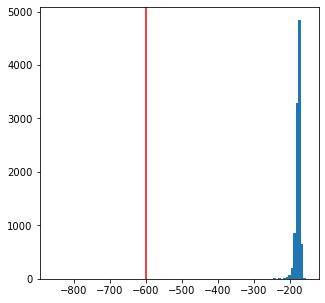

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
_ = plt.hist(probs, bins=100)
ax.axvline(prob_of_gt, color='r')

In [47]:
dummy_prior_norm.log_prob(gt_params_norm.unsqueeze(0))

tensor([-43.4859])

### Posterior predictives
Has to be done in a different virtual env with python 2.